In [40]:
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb

warnings.filterwarnings('ignore')

In [2]:
# init df
df = pd.read_csv('titanic.csv', sep=";")

In [3]:
sex = df[['PassengerId', 'Sex']]

In [4]:
sex

,PassengerId,Sex
0,1,male
1,2,female
2,3,female
3,4,female
4,5,male
...,...,...
886,887,male
887,888,female
888,889,female
889,890,male


In [5]:
pd.get_dummies(sex, columns=['Sex'])

,PassengerId,Sex_female,Sex_male,Sex_unknown
0,1,0,1,0
1,2,1,0,0
2,3,1,0,0
3,4,1,0,0
4,5,0,1,0
...,...,...,...,...
886,887,0,1,0
887,888,1,0,0
888,889,1,0,0
889,890,0,1,0


In [6]:
age = df[['PassengerId', 'Age']]

In [7]:
age

,PassengerId,Age
0,1,22.0
1,2,38.0
2,3,26.0
3,4,35.0
4,5,35.0
...,...,...
886,887,27.0
887,888,19.0
888,889,NaN
889,890,26.0


In [8]:
age['age_bins'] = pd.cut(df['Age'], bins=4)

In [9]:
age = pd.get_dummies(age, columns=['age_bins'])

In [10]:
age.drop(columns=['Age'])

,PassengerId,"age_bins_(0.34, 20.315]","age_bins_(20.315, 40.21]","age_bins_(40.21, 60.105]","age_bins_(60.105, 80.0]"
0,1,0,1,0,0
1,2,0,1,0,0
2,3,0,1,0,0
3,4,0,1,0,0
4,5,0,1,0,0
...,...,...,...,...,...
886,887,0,1,0,0
887,888,1,0,0,0
888,889,0,0,0,0
889,890,0,1,0,0


In [11]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Braund; Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,Heikkinen; Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,Allen; Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,Montvila; Rev. Juozas,male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,Graham; Miss. Margaret Edith,female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston; Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,Behr; Mr. Karl Howell,male,26.0,0,0,111369,30.0000,C148,C


In [12]:
# preprocess data
cols = list(df.columns)
a, b = cols.index('Survived'), cols.index('Embarked')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

df.drop(["Embarked", "PassengerId", "Cabin", "Ticket", "Name"], axis=1, inplace=True)

df = df.replace({'Sex': {'female': 0, 'male': 1}})

df = df.drop(df[(df.Sex == 'unknown') | (df.Age == 'NaN')].index)

df = df.dropna()

df = df.reset_index(drop=True)

cols = list(df.columns)
a, b = cols.index('Pclass'), cols.index('Age')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

cols = list(df.columns)
a, b = cols.index('Fare'), cols.index('Sex')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]


train_df, test_df = train_test_split(df, test_size=0.3)

x_train, y_train = train_df.to_numpy()[:,:-1], train_df.to_numpy()[:,-1]
x_test, y_test = test_df.to_numpy()[:,:-1], test_df.to_numpy()[:,-1]


std_scaler = StandardScaler().fit(x_train[:, :2])
minmax_scaler = MinMaxScaler().fit(x_train[:, 2:])

def preprocessor(X):
    A = deepcopy(X)
    A[:, :2] = std_scaler.transform(X[:, :2])
    A[:, 2:] = minmax_scaler.transform(X[:, 2:])
    return A

preprocessor_transformer = FunctionTransformer(preprocessor)

p1 = Pipeline([('Scaler', preprocessor_transformer),
              ('Logistic Regression', LogisticRegression())])

y_train=y_train.astype('int')

In [13]:
# training model
p1.fit(x_train, y_train)
train_pred_prob = p1.predict_proba(x_train)[:, 1]
test_pred_prob = p1.predict_proba(x_test)[:, 1]
train_pred = p1.predict(x_train)
test_pred = p1.predict(x_test)

In [37]:
def goeGINI(y_true, y_pred_proba):
    y_pred_proba = pd.Series(y_pred_proba) 
    y_pred = np.array(y_pred_proba.map(lambda x: 1 if x > 0.5 else 0))
    final_prob_target_and_class = np.column_stack([y_pred_proba.T, y_pred.T, y_true.T]).astype(float)
    final_prob_target_and_class = final_prob_target_and_class[np.argsort(final_prob_target_and_class[:, 0])][::-1]
    match = np.zeros((final_prob_target_and_class.shape[0],))

    for i in range(final_prob_target_and_class.shape[0]):
        match[i] = final_prob_target_and_class[i, 2]

    n = match.sum().astype(int)
    m = (match.shape[0]-n).astype(int)

    coord_y = np.linspace(0, 1, num = n+1)
    coord_x = np.linspace(0, 1, num = m+1)
    coords = np.zeros((n+m+1, 2))

    h_i = w_i = 0
    coords[0] = coord_x[0], coord_y[0]
    for i in range(1, n+m):
        if match[i-1] == 1:
            h_i += 1
        else:
            w_i += 1
        coords[i] = coord_x[w_i], coord_y[h_i]

    coords[-1] = 1, 1
    plt.scatter(coords[:, 0], coords[:, 1], marker = ",")
    plt.show()
    
    # fit polynomial w/ high degree
    deg = 100
    z = np.polyfit(coords[:, 0], coords[:, 1], deg)
    x = np.array(coords[:, 0])
    y = np.zeros((len(coords[:, 0],))) 

    for i in range(len(x)):
        for j in range(deg+1):
            y[i] += (z[j] * (x[i] ** (deg - j)))  
    y = y.clip(min=0, max=1)
    plt.plot(x, y)
    plt.plot(coords[:, 0], coords[:, 1])
    plt.show()
    aucroc = 0
    for i in range(deg+1):
        aucroc += z[i]/(deg-i+1)
    gini_doge = 2 * aucroc - 1
    gini_sklearn = 2 * roc_auc_score(final_prob_target_and_class[:, 2], final_prob_target_and_class[:, 0]) - 1 
    print(f"gini_doge = {gini_doge}\ngini_sklearn = {gini_sklearn}\nabs = {abs(gini_sklearn-gini_doge)}")
    

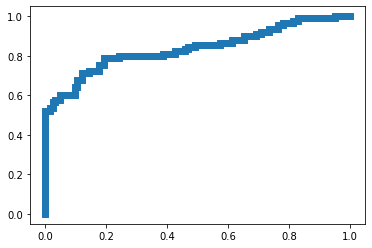

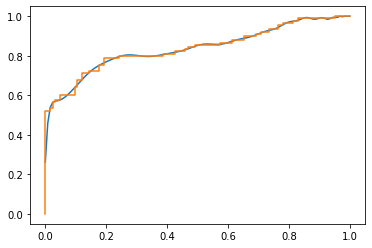

gini_doge = 0.6704541752874467
gini_sklearn = 0.6766129032258064
abs = 0.006158727938359698


In [38]:
goeGINI(y_test, test_pred_prob)

In [41]:
df2 = pd.read_csv('bank.csv')

In [44]:
df2

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,target
0,2736.0,1115.0,228.0,0.0,0.0,24.0,2.0,0.0,0.0,1.0,1.0,5068.0,1.0
1,3258.0,1177.0,217.0,2.0,0.0,23.0,1.0,743.0,0.0,0.0,1.0,5639.0,0.0
2,2104.0,2040.0,111.0,0.0,0.0,24.0,8.0,5793.0,2.0,1.0,0.0,5707.0,1.0
3,5435.0,289.0,308.0,0.0,0.0,21.0,1.0,0.0,1.0,0.0,0.0,4704.0,0.0
4,6899.0,1822.0,459.0,2.0,0.0,25.0,2.0,3696.0,0.0,1.0,1.0,3925.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1599.0,1999.0,380.0,0.0,1.0,21.0,5.0,0.0,1.0,1.0,0.0,4827.0,0.0
9996,161.0,1336.0,125.0,0.0,1.0,17.0,10.0,124.0,0.0,1.0,1.0,5087.0,0.0
9997,717.0,1570.0,318.0,0.0,0.0,18.0,7.0,0.0,0.0,0.0,1.0,2062.0,1.0
9998,4656.0,2345.0,381.0,1.0,1.0,24.0,3.0,427.0,1.0,1.0,0.0,4639.0,1.0


In [43]:
df2.drop(columns=['Unnamed: 0'], inplace=True)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=['target']), df2.target, test_size=0.2)

In [48]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [54]:
y_proba = clf.predict_proba(X_test)[:, 1]

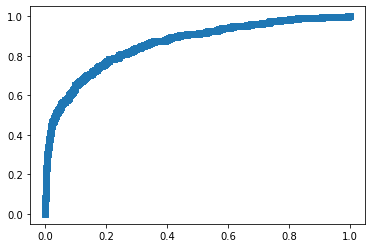

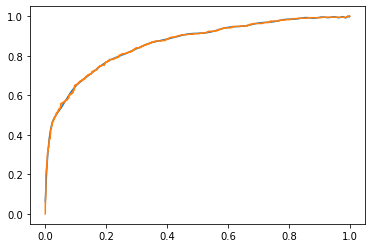

gini_doge = 0.7245444964111509
gini_sklearn = 0.7246861653641314
abs = 0.00014166895298051152


In [56]:
goeGINI(y_test, y_proba)